In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Preprocessing & Adjusting Dataframe
Due to conflicts in the **metadata.csv** file, approximately 900 images were deemed unusable. As a result, we have decided to create our own dataframe to address this issue.
The structure of the DataFrame approximately will be the same as the original one

In [2]:
metadata = "/kaggle/input/x-ray-covid-normal-pne/covid19-pneumonia-normal-chest-xraypa-dataset/metadata.csv"

In [3]:
basedir = "/kaggle/input/x-ray-covid-normal-pne/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset"

In [6]:
#Creates a list consist of paths of the images.
datalist = []
for folder in os.listdir(basedir):
    for item in os.listdir(basedir+"/"+folder):
        item_str = basedir+"/"+folder+"/"+item
        #print(basedir+"/"+folder+"/"+item)
        datalist.append(item_str)


DataFrame columns stuctured as *directory* and *class*.
Class columns hold the class of the image **(normal,covid,pneumonia)**

In [7]:
# Create an empty DataFrame
df = pd.DataFrame(columns=["directory", "class"])

# Iterate over the data list and append rows to the DataFrame
for data in datalist:
    df = df.append({"directory": data, "class": data.split("/")[-2]}, ignore_index=True)

# Print the resulting DataFrame
print(df)


                                              directory      class
0     /kaggle/input/x-ray-covid-normal-pne/covid19-p...  pneumonia
1     /kaggle/input/x-ray-covid-normal-pne/covid19-p...  pneumonia
2     /kaggle/input/x-ray-covid-normal-pne/covid19-p...  pneumonia
3     /kaggle/input/x-ray-covid-normal-pne/covid19-p...  pneumonia
4     /kaggle/input/x-ray-covid-normal-pne/covid19-p...  pneumonia
...                                                 ...        ...
4570  /kaggle/input/x-ray-covid-normal-pne/covid19-p...      covid
4571  /kaggle/input/x-ray-covid-normal-pne/covid19-p...      covid
4572  /kaggle/input/x-ray-covid-normal-pne/covid19-p...      covid
4573  /kaggle/input/x-ray-covid-normal-pne/covid19-p...      covid
4574  /kaggle/input/x-ray-covid-normal-pne/covid19-p...      covid

[4575 rows x 2 columns]


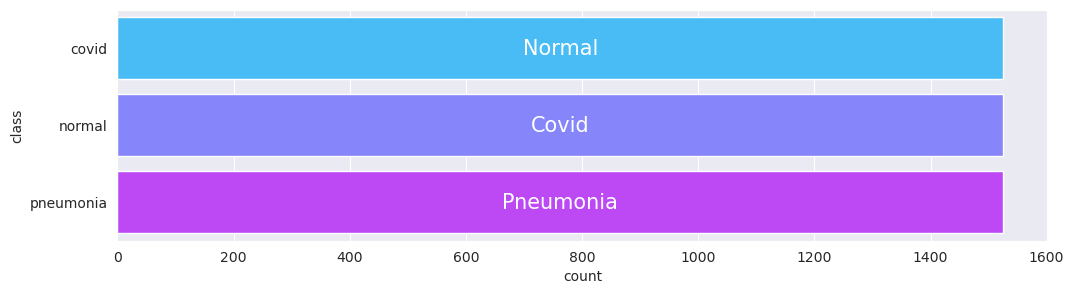

In [8]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='class'), y ='class', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Covid', 'Pneumonia'], 
              label_type='center', size=15, color='w')
plt.show()

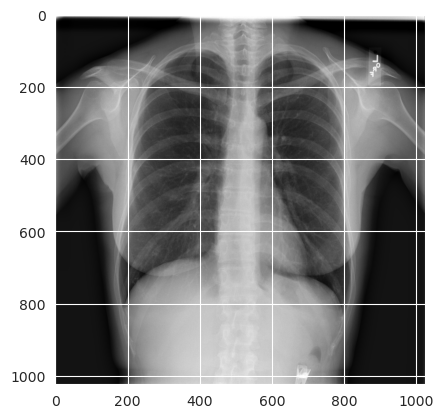

In [9]:
from tensorflow.keras.utils import load_img

sample = random.choice(df['directory'])
image = load_img(sample)
plt.imshow(image)
plt.show()

# Train Test Validation Split
**Training Set (80%):** The largest portion of the dataset, comprising 80% of the data, is used for training the model. This set is used to optimize the model's parameters and learn patterns from the data.

**Validation Set (10%):** The validation set is used to fine-tune the model during training and to evaluate its performance on unseen data. It helps in selecting the best model architecture, hyperparameters, or making early stopping decisions. The model does not directly learn from this set, but it provides insights into its generalization ability.

**Test Set (10%):** The test set is used to assess the final performance and generalization of the trained model. It represents unseen data that the model has not encountered during training or validation. The test set helps to estimate how the model is expected to perform in real-world scenarios.

In [10]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['class'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [11]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['class'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [12]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

When you use **class_mode='categorical'** in the **flow_from_dataframe** function of TensorFlow's **ImageDataGenerator**, it automatically converts the categorical labels to numeric form. The mapping of the original labels to their corresponding numeric values can be obtained from the **class_indices** attribute of the train_generator object.

In [13]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='directory',
    y_col='class',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 3660 validated image filenames belonging to 3 classes.


In [14]:
class_mapping = train_generator.class_indices

# Print the mapping
print(class_mapping)

{'covid': 0, 'normal': 1, 'pneumonia': 2}


In [15]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='directory',
    y_col='class',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 458 validated image filenames belonging to 3 classes.


In [16]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='directory',
    y_col='class',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 457 validated image filenames belonging to 3 classes.


# Xception from scratch
We implemented the **Xception architecture** from scratch based on the original paper titled "The Xception Architecture" by François Chollet. The Xception architecture consists of three main components: the entry flow, the middle flow, and the exit flow.

The data first passes through the entry flow, which consists of a series of convolutional and separable convolutional layers. These layers are designed to capture low-level features and gradually increase the complexity of the representations. It should be noted that all convolutional and separable convolutional layers are followed by batch normalization, which helps stabilize and improve the training process.

Next, the data goes through the middle flow, which is repeated eight times. The middle flow is composed of a sequence of separable convolutional layers. These layers are responsible for capturing more abstract and higher-level features in the data.

Finally, the data flows through the exit flow, which further processes the feature maps generated by the middle flow. The exit flow typically includes pooling layers, fully connected layers, and dropout layers, which help reduce overfitting. In our implementation, the last layer of the exit flow utilizes three units from the DenseNet architecture for classification into three categories.

In [79]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = Dense (units = 3, activation = 'softmax')(x)
    
    return x

In [80]:
input = Input(shape = (224,224,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 112, 112, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_57 (BatchN  (None, 112, 112, 32  128        ['conv2d_22[0][0]']              
 ormalization)                  )                                                           

During compilation, the **Adam** optimizer is specified with a learning rate of 3e-4. The Adam optimizer is a popular optimization algorithm that adjusts the model's weights during training to minimize the loss function.

The loss function is set to **categorical crossentropy**, which is suitable for multi-class classification problems. Categorical crossentropy measures the dissimilarity between the true labels and the predicted probabilities of the classes.

The chosen evaluation metric is **accuracy**, which calculates the percentage of correctly predicted samples out of the total number of samples.

In [81]:
model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

The **EarlyStopping** callback is utilized to stop the training if the monitored metric, in this case, the loss **(monitor='loss')**, does not improve for a certain number of epochs defined by the **patience** parameter. This early stopping mechanism helps prevent overfitting and saves time by terminating training when further improvement is unlikely.

The **ReduceLROnPlateau** callback serves the purpose of reducing the learning rate during training based on certain conditions.

In [82]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

# Training of Xception

In [83]:
 history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=10,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

Epoch 1/10
115/115 [==============================] - 123s 834ms/step - loss: 0.5885 - accuracy: 0.7795 - val_loss: 1.1061 - val_accuracy: 0.3319 - lr: 3.0000e-04
Epoch 2/10
115/115 [==============================] - 95s 821ms/step - loss: 0.3881 - accuracy: 0.8590 - val_loss: 1.1004 - val_accuracy: 0.3319 - lr: 3.0000e-04
Epoch 3/10
115/115 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8896
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
115/115 [==============================] - 95s 823ms/step - loss: 0.3200 - accuracy: 0.8896 - val_loss: 1.0917 - val_accuracy: 0.3319 - lr: 3.0000e-04
Epoch 4/10
115/115 [==============================] - 96s 831ms/step - loss: 0.2611 - accuracy: 0.9142 - val_loss: 1.0706 - val_accuracy: 0.3450 - lr: 1.5000e-04
Epoch 5/10
115/115 [==============================] - 94s 810ms/step - loss: 0.2322 - accuracy: 0.9249 - val_loss: 0.9262 - val_accuracy: 0.5480 - lr: 1.5000e-04
Epoch 6/10
115/115 [========

# Xception from scratch no initial weights scores:
Train score: 0.9388 

Test score: 0.8556

In [84]:
 model.evaluate(test_set)


15/15 [==============================] - 6s 405ms/step - loss: 0.3197 - accuracy: 0.8556


[0.3196581304073334, 0.8555798530578613]

In [85]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['covid','normal', 'pneumonia'], digits=5))

15/15 [==============================] - 7s 368ms/step


              precision    recall  f1-score   support

       covid    0.86441   1.00000   0.92727       153
      normal    0.90909   0.65789   0.76336       152
   pneumonia    0.81176   0.90789   0.85714       152

    accuracy                        0.85558       457
   macro avg    0.86175   0.85526   0.84926       457
weighted avg    0.86176   0.85558   0.84943       457



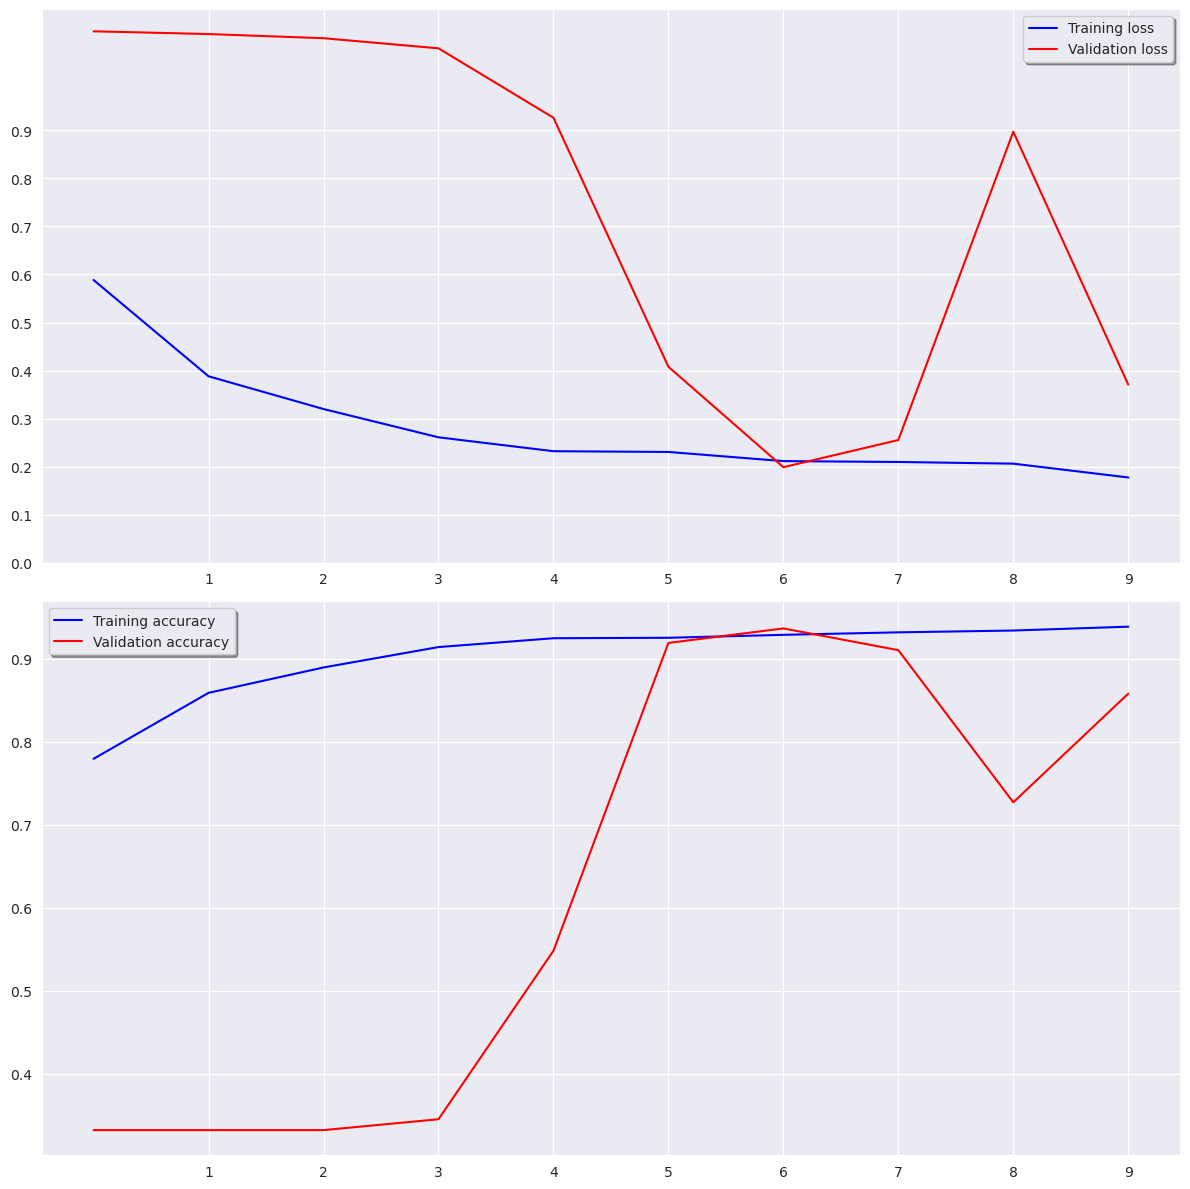

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 10, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, 10, 1))

# Add the legend
ax1.legend(loc='best', shadow=True)
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()


In [89]:
from sklearn.metrics import confusion_matrix
import numpy as np

target_names = ['COVID','Normal', 'Pneumonia']

# Assuming you have a trained model called 'model'
# and a test dataset called 'test_data' with corresponding labels 'test_labels'

# Get the predictions for the test data
predictions = prob
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix with target names
cm = confusion_matrix(test_set.labels, predicted_labels)

# Print the confusion matrix with target names
print("Confusion Matrix:")
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(test_set.labels, predicted_labels, target_names=target_names))


Confusion Matrix:
[[153   0   0]
 [ 20 100  32]
 [  4  10 138]]
Classification Report:
              precision    recall  f1-score   support

       COVID       0.86      1.00      0.93       153
      Normal       0.91      0.66      0.76       152
   Pneumonia       0.81      0.91      0.86       152

    accuracy                           0.86       457
   macro avg       0.86      0.86      0.85       457
weighted avg       0.86      0.86      0.85       457



# Transfer Learning and Fine tuning

First step is to load the weights of the pre-trained model in the model architecture. Notice, that an additional argument is passed include_top = False, which states that we do not want to add the last layer of this architecture.

After initializing the Xception model, additional layers are added on top to customize the model for the specific classification task.

**GlobalAveragePooling2D**: This layer computes the average value for each feature map in the input and reduces the spatial dimensions of the data. It helps capture global information while reducing the number of parameters in the model.

**Dropout**: This layer randomly sets a fraction of input units to 0 during training, which helps prevent overfitting by introducing regularization.

**BatchNormalization**: This layer normalizes the activations of the previous layer, improving the stability and speed of training. It applies batch-wise normalization along the specified axis.

**Dense**: This layer is a fully connected layer with 3 units, representing the number of classes in the classification task. The activation function used is softmax, which outputs probabilities for each class.

In [90]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)

x = GlobalAvgPool2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
    
out = Dense(units = 3, activation = 'softmax')(x)

# out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)
model = keras.Model(inputs, out)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
___________________________________________

In [91]:
model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

In [92]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [93]:
history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=5,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

Epoch 1/5
115/115 [==============================] - 92s 772ms/step - loss: 0.7017 - accuracy: 0.7189 - val_loss: 0.5140 - val_accuracy: 0.8253 - lr: 3.0000e-04
Epoch 2/5
115/115 [==============================] - 87s 760ms/step - loss: 0.4967 - accuracy: 0.8328 - val_loss: 0.4718 - val_accuracy: 0.8297 - lr: 3.0000e-04
Epoch 3/5
115/115 [==============================] - 87s 755ms/step - loss: 0.4515 - accuracy: 0.8459 - val_loss: 0.4451 - val_accuracy: 0.8297 - lr: 3.0000e-04
Epoch 4/5
115/115 [==============================] - 88s 762ms/step - loss: 0.4181 - accuracy: 0.8514 - val_loss: 0.4052 - val_accuracy: 0.8537 - lr: 3.0000e-04
Epoch 5/5
115/115 [==============================] - 87s 759ms/step - loss: 0.3976 - accuracy: 0.8658 - val_loss: 0.3998 - val_accuracy: 0.8472 - lr: 3.0000e-04


# Fine Tuning
Unfreezing all the layers for fine tuning. And training the model with a lower learning rate.

In [94]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-5),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
__________________________________________

In [95]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.000001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)

In [96]:
history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=15,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

Epoch 1/15
115/115 [==============================] - 124s 838ms/step - loss: 0.3223 - accuracy: 0.8910 - val_loss: 0.2526 - val_accuracy: 0.8974 - lr: 3.0000e-05
Epoch 2/15
115/115 [==============================] - 95s 826ms/step - loss: 0.2043 - accuracy: 0.9347 - val_loss: 0.1882 - val_accuracy: 0.9541 - lr: 3.0000e-05
Epoch 3/15
115/115 [==============================] - 96s 828ms/step - loss: 0.1828 - accuracy: 0.9352 - val_loss: 0.1831 - val_accuracy: 0.9476 - lr: 3.0000e-05
Epoch 4/15
115/115 [==============================] - ETA: 0s - loss: 0.1500 - accuracy: 0.9500
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
115/115 [==============================] - 95s 825ms/step - loss: 0.1500 - accuracy: 0.9500 - val_loss: 0.2013 - val_accuracy: 0.9454 - lr: 3.0000e-05
Epoch 5/15
115/115 [==============================] - 98s 848ms/step - loss: 0.1251 - accuracy: 0.9568 - val_loss: 0.1854 - val_accuracy: 0.9520 - lr: 1.5000e-05
Epoch 6/15
115/115 [=======

# Transfer learning Fine Tuned Xception Test
Train accuracy : 96.69%

**Test accuracy : 94.53%**

In [97]:
 model.evaluate(test_set)


15/15 [==============================] - 6s 406ms/step - loss: 0.1332 - accuracy: 0.9453


[0.13316984474658966, 0.9452953934669495]

In [98]:
class_mapping = train_generator.class_indices
print(class_mapping)

{'covid': 0, 'normal': 1, 'pneumonia': 2}


In [99]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['COVID','Normal', 'Pneumonia'], digits=5))

15/15 [==============================] - 7s 426ms/step


              precision    recall  f1-score   support

       COVID    0.99329   0.96732   0.98013       153
      Normal    0.88304   0.99342   0.93498       152
   Pneumonia    0.97080   0.87500   0.92042       152

    accuracy                        0.94530       457
   macro avg    0.94904   0.94525   0.94518       457
weighted avg    0.94914   0.94530   0.94525       457



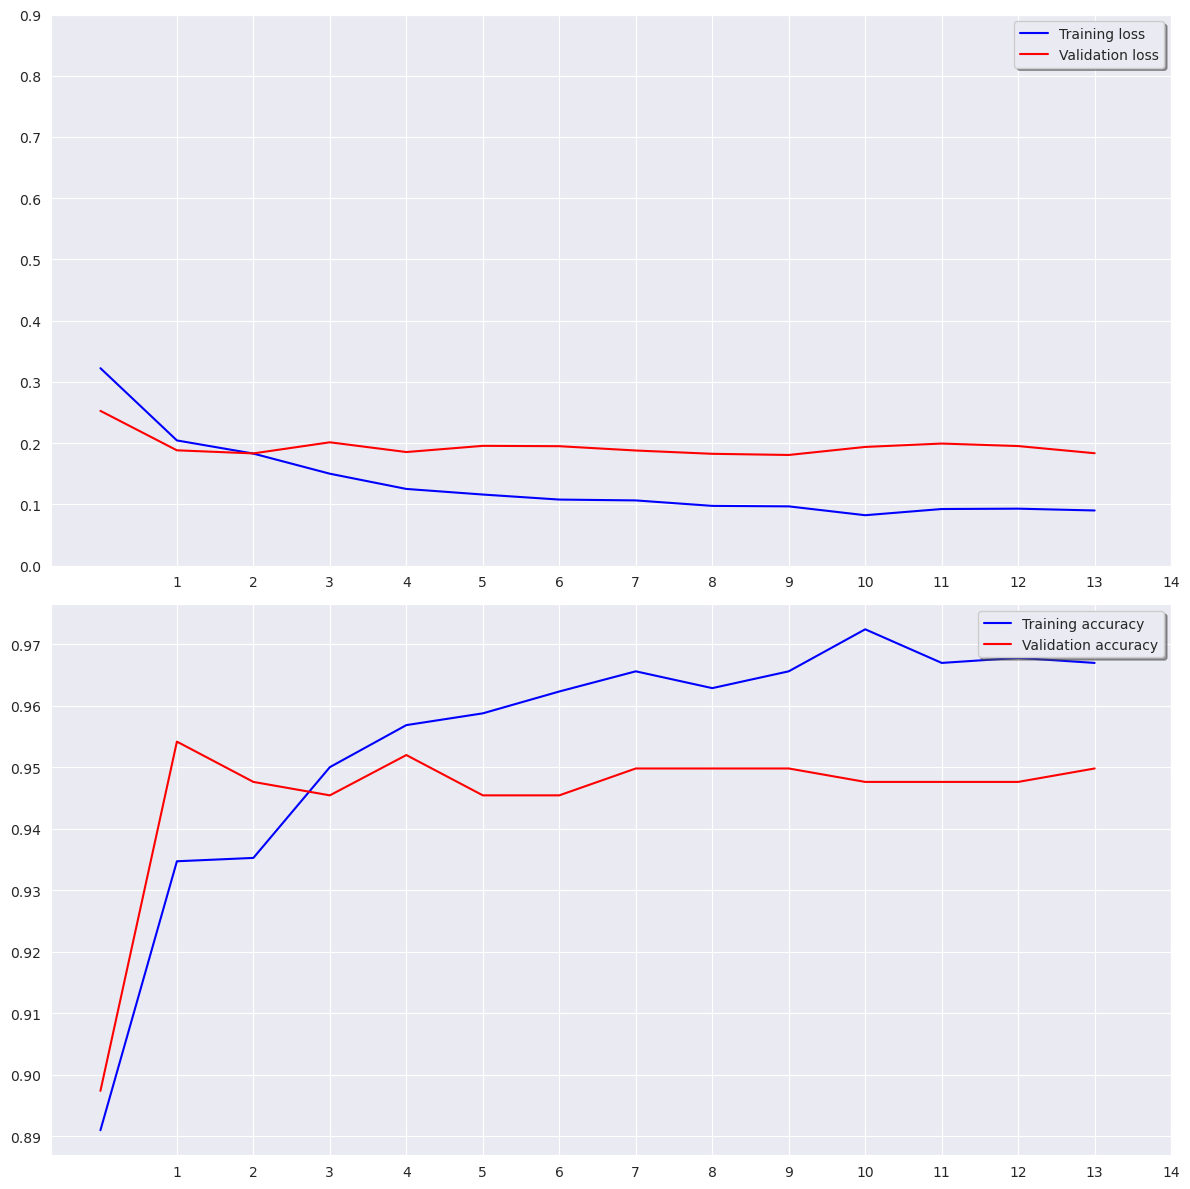

In [100]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, 15, 1))

# Add the legend
ax1.legend(loc='best', shadow=True)
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [101]:
from sklearn.metrics import confusion_matrix
import numpy as np

target_names = ['COVID','Normal', 'Pneumonia']

# Assuming you have a trained model called 'model'
# and a test dataset called 'test_data' with corresponding labels 'test_labels'

# Get the predictions for the test data
predictions = prob
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix with target names
cm = confusion_matrix(test_set.labels, predicted_labels)

# Print the confusion matrix with target names
print("Confusion Matrix:")
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(test_set.labels, predicted_labels, target_names=target_names))

Confusion Matrix:
[[148   2   3]
 [  0 151   1]
 [  1  18 133]]
Classification Report:
              precision    recall  f1-score   support

       COVID       0.99      0.97      0.98       153
      Normal       0.88      0.99      0.93       152
   Pneumonia       0.97      0.88      0.92       152

    accuracy                           0.95       457
   macro avg       0.95      0.95      0.95       457
weighted avg       0.95      0.95      0.95       457



<Figure size 640x480 with 0 Axes>

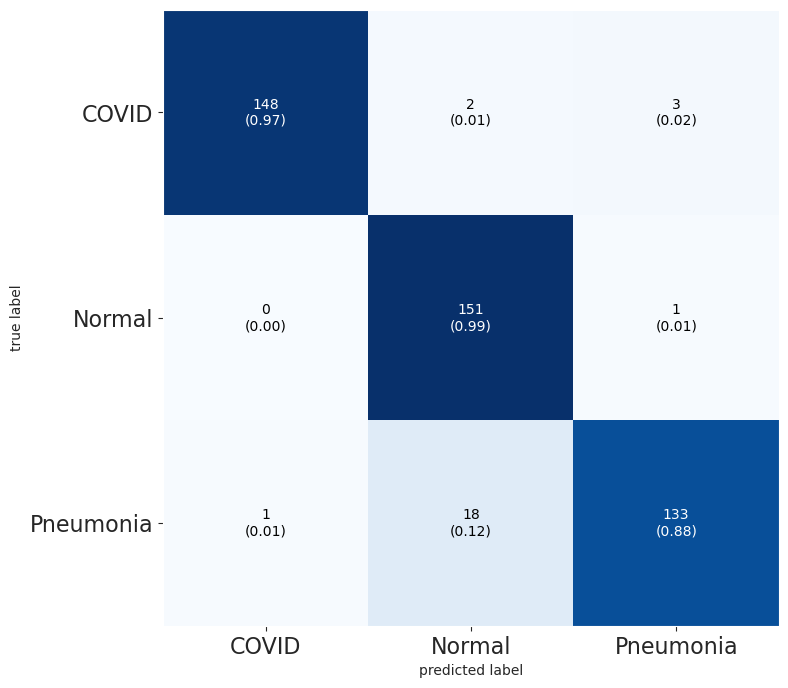

In [102]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues,show_normed=True)
plt.xticks(range(3), ['COVID','Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(3), ['COVID','Normal', 'Pneumonia'], fontsize=16)
plt.show()

True value is : pneumonia
1/1 [==============================] - 0s 22ms/step
Prediction is:
Normal


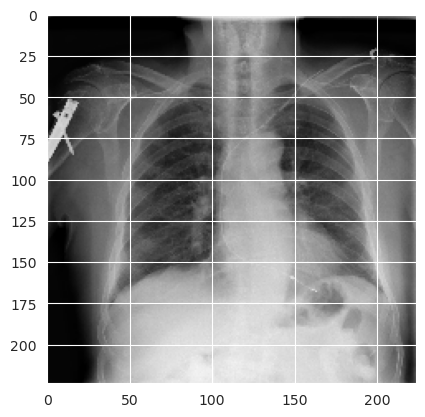

In [109]:
sample = random.choice(test_data['directory'])
category = sample.split('/')[-2]

print(f'True value is : {category}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)/255
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("COVID")
elif result == 1:
    print("Normal")
else:
    print("Pneumonia ")
    
plt.imshow(image)

In [40]:
model.save('xceptionfinetuned.h5')
